In [1]:
library(tidyverse)
library(cowplot)

palette <- c('HSIC Lasso' = '#c994c7', 'HSIC Lasso, B = 50' = '#df65b0',
             'HSIC Lasso, B = 20' = '#e7298a', 'HSIC Lasso, B = 10' = '#ce1256',
             'HSIC Lasso, B = 5' = '#67001f',
             'LARS' = '#2171b5', 'mRMR' = '#238443')
methods <- c('HSIC Lasso', 'HSIC Lasso, B = 50',
             'HSIC Lasso, B = 40','HSIC Lasso, B = 30',
             'HSIC Lasso, B = 20','HSIC Lasso, B = 10',
             'HSIC Lasso, B = 5', 'mRMR', 'LARS')
samples <-  c('100 samples', '1000 samples', '10000 samples')
feats <-  c('1000 features', '2500 features', '5000 features', '10000 features')

summarize_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        group_by(model, selected) %>%
        summarize(n = n(), ended = sum(!is.na(accuracy)),
                  sem = sd(accuracy) / sqrt(ended), accuracy = mean(accuracy) ) %>%
        ungroup %>%
        mutate(label = label)

}

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.0.0     ✔ purrr   0.2.5
✔ tibble  1.4.2     ✔ dplyr   0.7.6
✔ tidyr   0.8.1     ✔ stringr 1.3.1
✔ readr   1.1.1     ✔ forcats 0.3.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::flatten() masks jsonlite::flatten()
✖ dplyr::lag()     masks stats::lag()

Attaching package: ‘cowplot’

The following object is masked from ‘package:ggplot2’:

    ggsave



Warning message:
“Removed 15 rows containing missing values (geom_errorbar).”Warning message:
“Removed 15 rows containing missing values (geom_point).”Warning message:
“Removed 10 rows containing missing values (geom_path).”

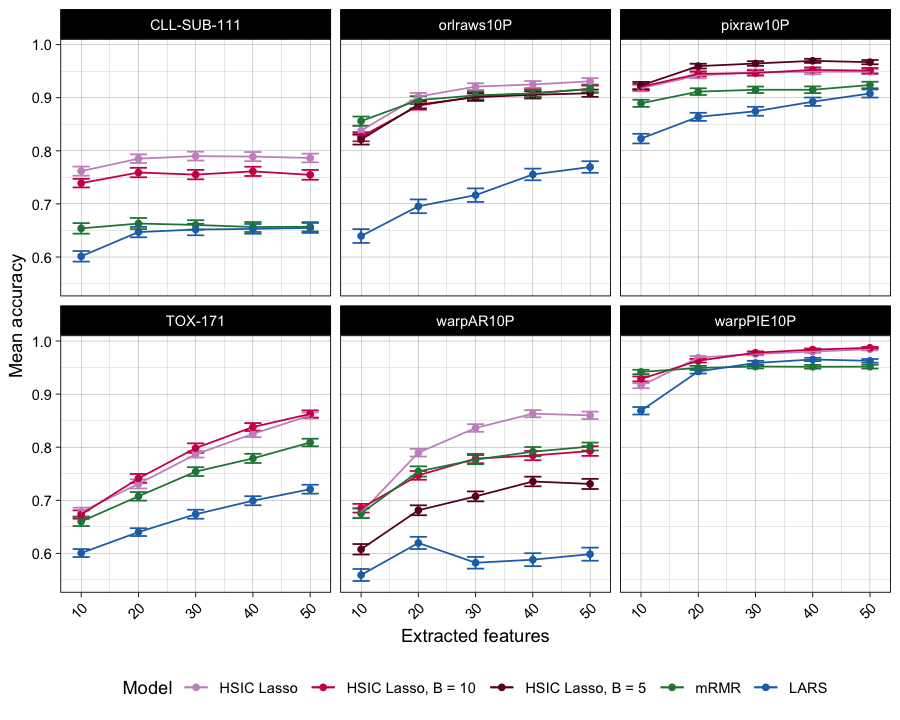

In [2]:
CLLSUB111 <- summarize_benchmark('../results/asu/CLL-SUB-111_prediction.tsv')
pixraw10P <- summarize_benchmark('../results/asu/pixraw10P_prediction.tsv')
warpAR10P <- summarize_benchmark('../results/asu/warpAR10P_prediction.tsv')
orlraws10P <- summarize_benchmark('../results/asu/orlraws10P_prediction.tsv')
warpPIE10P <- summarize_benchmark('../results/asu/warpPIE10P_prediction.tsv')
tox171 <- summarize_benchmark('../results/asu/TOX-171_prediction.tsv')

predictions <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                         orlraws10P, warpPIE10P, tox171) %>%
    mutate(model = factor(model, levels = methods))

options(repr.plot.width=7.5, repr.plot.height=6)
predictions %>%
    ggplot(aes(x = selected, y = accuracy, color = model)) +
        geom_errorbar(aes(ymin = accuracy - sem, ymax = accuracy + sem), width = 3) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = 'Extracted features', y = 'Mean accuracy', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label)

In [3]:
read_benchmark <- function(x) {
    
    label <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_prediction.tsv', '', .)
    
    read_tsv(x, col_types = 'ciid') %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
           model = gsub('-B=0', '', model),
           model = gsub('-B=', ', B = ', model),
           model = gsub('-M=3', '', model),
           model = factor(model, levels = methods),
           label = label) %>%
        filter(!is.na(accuracy))
}

CLLSUB111 <- read_benchmark('../results/asu/CLL-SUB-111_prediction.tsv')
pixraw10P <- read_benchmark('../results/asu/pixraw10P_prediction.tsv')
warpAR10P <- read_benchmark('../results/asu/warpAR10P_prediction.tsv')
orlraws10P <- read_benchmark('../results/asu/orlraws10P_prediction.tsv')
warpPIE10P <- read_benchmark('../results/asu/warpPIE10P_prediction.tsv')
tox171 <- read_benchmark('../results/asu/TOX-171_prediction.tsv')

predictions <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                         orlraws10P, warpPIE10P, tox171)

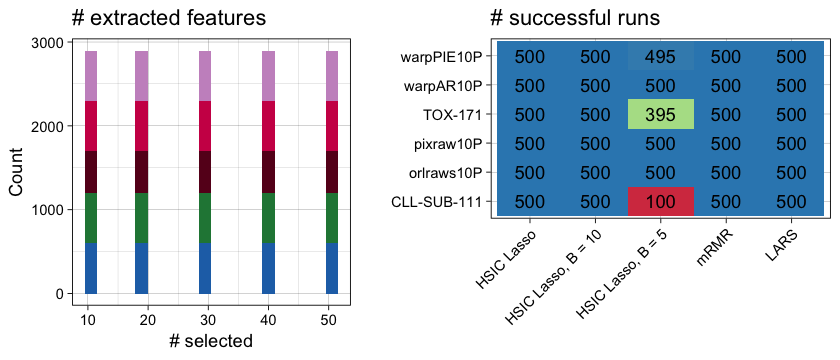

In [4]:
options(repr.plot.width=7, repr.plot.height=3)

selected <- predictions %>%
    ggplot(aes(selected, fill = model)) +
        geom_histogram(bins = 20) +
        theme_linedraw() +
        scale_fill_manual(values = palette) +
        labs(x = '# selected', y = 'Count', fill = 'Method', title = '# extracted features') +
        theme(legend.position = 'none')

finished <- predictions %>%
    group_by(model, label) %>%
    summarize(ended = n()) %>%
    ggplot(aes(x = factor(model), y = factor(label), fill = ended, label = ended)) +
        geom_tile() +
        geom_text() +
        theme_linedraw() +
        theme(legend.position = 'none',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = '', y = '', title = '# successful runs') + 
        scale_fill_distiller(palette = "Spectral", direction = 1)

plot_grid(selected, finished, rel_widths = c(3,4))

In [5]:
read_stability <- function(x) { 
    
    experiment <- strsplit(x, '/') %>% unlist %>% .[4] %>% gsub('_stability.tsv', '', .)
    
    finished <- filter(predictions, label == experiment) %>%
        select(model, selected, i)
    
    read_tsv(x, col_types = 'ciiiicd') %>% 
        select(-samples, -features) %>%
        mutate(model = gsub('HSIC_lasso', 'HSIC Lasso', model),
               model = gsub('-B=0', '', model),
               model = gsub('-B=', ', B = ', model),
               model = gsub('-M=3', '', model),
               model = factor(model, levels = methods)) %>%
        separate(comparison, c('i1', 'i2'), sep = '-') %>%
        mutate(i1 = as.integer(i1), i2 = as.integer(i2)) %>%
        inner_join(finished, by = c('model', 'causal' = 'selected', 'i1'= 'i')) %>%
        inner_join(finished, by = c('model', 'causal' = 'selected', 'i2'= 'i')) %>%
        group_by(model, causal) %>%
        summarize(sem = sd(jaccard) / n(), jaccard = mean(jaccard) ) %>%
        ungroup %>%
        mutate(label = experiment)

}

CLLSUB111 <- read_stability('../results/asu/CLL-SUB-111_stability.tsv')
pixraw10P <- read_stability('../results/asu/pixraw10P_stability.tsv')
warpAR10P <- read_stability('../results/asu/warpAR10P_stability.tsv')
orlraws10P <- read_stability('../results/asu/orlraws10P_stability.tsv')
warpPIE10P <- read_stability('../results/asu/warpPIE10P_stability.tsv')
tox171 <- read_stability('../results/asu/TOX-171_stability.tsv')

stability <- bind_rows(CLLSUB111, pixraw10P, warpAR10P, 
                       orlraws10P, warpPIE10P, tox171)

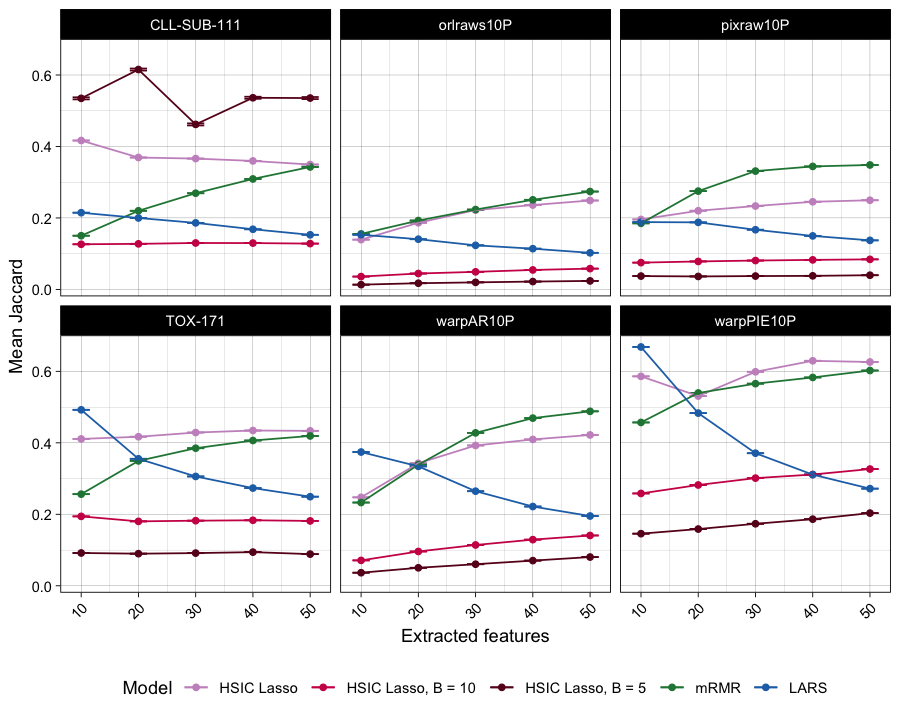

In [6]:
options(repr.plot.width=7.5, repr.plot.height=6)
stability %>%
    ggplot(aes(x = causal, y = jaccard, color = model)) +
        geom_errorbar(aes(ymin = jaccard - sem, ymax = jaccard + sem), width = 3) +
        geom_point() +
        geom_line() +
        theme_linedraw() +
        theme(legend.position = 'bottom',
              axis.text.x = element_text(angle = 45, hjust = 1)) +
        labs(x = 'Extracted features', y = 'Mean Jaccard', color = 'Model') +
        scale_color_manual(values = palette) +
        facet_wrap(~label)